<a href="https://colab.research.google.com/github/z-gursky/Dementia/blob/main/Copy_of_Chat_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook will be creating a user friendly healthcare chatbot. I dove deep into [Leading causes of death in america](https://www.kaggle.com/kingburrito666/leading-causes-of-death-usa) dataset and used these diseases as they may be most prevalent. I will be starting off with one of the leading causes of death, cancer, along with diabetes and will continue to add more diseases.

The goal of developing a chatbot is to have one place to get information regarding each disease. This will save time for the user and also cut down costs for healthcare providers not needing addiontional customer service representatives. 

The first part of this notebook will focus scraping information from the web utilizing beautiful soup

In [1]:
import requests
from bs4 import BeautifulSoup

def website(link):
  website_url = link
  website_response = requests.get(website_url)

  # Make sure that you got a valid response
  if(website_response.ok):
    # Get the full data from the response
    website_response = website_response.text
  return website_response
#overview of cancer 
cancer_data = website('https://www.cancer.gov/about-cancer/understanding/what-is-cancer')
#risks involved with cancer
cancer_risk = website('https://www.cancer.gov/about-cancer/causes-prevention/risk')
#prevention of cancer 
cancer_prevention = website('https://www.cancer.gov/about-cancer/causes-prevention/patient-prevention-overview-pdq')
#all information came from single page 
diabetes_data = website('https://www.healthline.com/health/type-2-diabetes')

In [2]:
def soup(disease_data):
  soup = BeautifulSoup(disease_data, 'html.parser')
  return soup

# general data on cancer
cancer_data = soup(cancer_data)

# risks involved with cancer
cancer_risk = soup(cancer_risk)

# how to prevent cancer
cancer_prevention = soup(cancer_prevention)

# general data of cancer along with risks and prevention 
diabetes_data = soup(diabetes_data)

In [ ]:
def data_selection(disease_soup):
  # this information happened to all be from article -> h2 -> h3
  div = disease_soup.find('div', class_='resize-content')
  items_list = div.find('section')
  final_items = items_list.find_all('p')
  return final_items
cancer_data = data_selection(cancer_data)
cancer_prevention = data_selection(cancer_prevention)

In [ ]:
# was no 'section' for this part
cancer_risk = cancer_risk.find('div', class_='resize-content')
cancer_risk = cancer_risk.find_all('p')

#different for diabetes
diabetes_data = diabetes_data.find('div', class_='css-z468a2')
diabetes_data = diabetes_data.find('article')
diabetes_data = diabetes_data.find_all('p')

The next part is converting the data to sentences and downloading to desktop to access as text file moving forward. This will be specific to the user, but I opened a blank text file and wrote to this and downloaded. The files will be seen in the following part of this notebook. 

In [ ]:
from collections import Counter
import nltk
import spacy
import re
from google.colab import files
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt


#uploading from text downloaded to desktop 
cancer_data_upload = files.upload()
cancer_risk_upload = files.upload()
cancer_prevention_upload = files.upload()
diabetes_upload = files.upload()

Saving cancer_bot.txt to cancer_bot.txt


Saving cancer_bot2.txt to cancer_bot2.txt


Saving cancer_bot3.txt to cancer_bot3.txt


Saving diabetes_info.txt to diabetes_info.txt


In [ ]:
file_name = "cancer_bot.txt"
cancer_data_doc = cancer_data_upload[file_name].decode("utf-8")

file_name2 = "cancer_bot2.txt"
cancer_risk_doc = cancer_risk_upload[file_name2].decode("utf-8")

file_name3 = "cancer_bot3.txt"
cancer_prevention_doc = cancer_prevention_upload[file_name3].decode("utf-8")

file_name4 = "diabetes_info.txt"
diabetes_doc = diabetes_upload[file_name4].decode("utf-8")

In [ ]:
# Utility function for text cleaning
def text_cleaner(text):
    # mostly white spaces 
    text = re.sub(r'--',' ',text)
    text = re.sub(r'\n',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub(r"(\b|\s+\-?|^\-?)(\d+|\d*\.\d+)\b", " ", text)
    text = ' '.join(text.split())
    return text
cancer_data_doc = text_cleaner(cancer_data_doc)
cancer_risk_doc= text_cleaner(cancer_risk_doc)
cancer_prevention_doc = text_cleaner(cancer_prevention_doc)
diabetes_doc = text_cleaner(diabetes_doc)

Visualize the frequency or importance of words from each specific document using word cloud

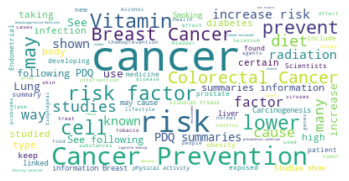

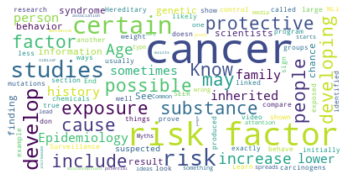

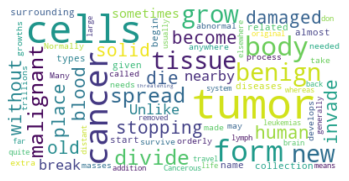

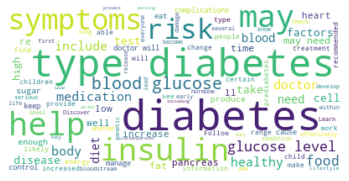

In [ ]:
# lower max_font_size, change the maximum number of word and lighten the background:
def word_cloud(document):
  visualizer = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(document)
  plt.figure()
  plt.imshow(visualizer, interpolation="bilinear")
  plt.axis("off")
  plt.show()
  return visualizer
wc_cancer_data= word_cloud(cancer_data_doc)
wc_cancer_risk = word_cloud(cancer_risk_doc)
wc_cancer_prevention = word_cloud(cancer_prevention_doc)
wc_diabetes_data = word_cloud(diabetes_doc)

In [ ]:
def sentences(disease_doc, disease_name):
  # parse the data
  nlp = spacy.load('en')
  info = nlp(disease_doc)
  # form text into sentences
  sentence = [[sent, disease_name] for sent in info.sents]
  return sentence
  
cancer_sents = sentences(cancer_data_doc, "Cancer")
cancer_sents2 = sentences(cancer_risk_doc, "Cancer")
cancer_sents3 = sentences(cancer_prevention_doc, "Cancer")
diabetes_sent = sentences(diabetes_doc, "Diabetes")

In [ ]:
import pandas as pd
# form all sentences into singal dataframe
sentences = pd.DataFrame(cancer_sents + cancer_sents2 + cancer_sents3 + diabetes_sent, columns = ["text", "disease"])

In [ ]:
# Get rid of stop words and punctuation,
# and lemmatize the tokens
for i, sentence in enumerate(sentences["text"]):
    sentences.loc[i, "text"] = " ".join(
        [token.lemma_ for token in sentence if not token.is_punct and not token.is_stop])

### **Term Frequency Inverse Document Frequency | Bag of words**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
def nlp_model(method, df):
  vectorizer = method
  
  # Applying the vectorizer
  X = vectorizer.fit_transform(df["text"])

  nlp_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
  sentences = pd.concat([nlp_df, df[["text", "disease"]]], axis=1)
  return sentences

# term frequency-inverse document frequency, one gram
tfidf_one_gram = nlp_model(TfidfVectorizer(
    max_df=.05, min_df=2, use_idf=True, norm=u'l2', smooth_idf=True), sentences)

# term frequency-inverse document frequency, two gram
tfidf_two_gram = nlp_model(TfidfVectorizer(
    max_df=.05, min_df=2, use_idf=True, norm=u'l2', smooth_idf=True, ngram_range=(2,2)), sentences)

# bag of words, one gram
bow_one_gram = nlp_model(CountVectorizer(analyzer='word'), sentences)

# bag of words, one gram
bow_two_gram = nlp_model(CountVectorizer(analyzer='word', ngram_range=(2,2)), sentences)

### **Setting up a function with grid search to find the best hyperparameters and best model.**

In [ ]:
def nlp_algorithm(df):
  Y = df.iloc[:, -1].values
  X = np.array(df.drop(['text','disease'], 1))

  # We split the dataset into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

  # Models
  lr_params = {"penalty": ["l2"]}
  lr = LogisticRegression()

  rfc_params = {"n_estimators": [3, 5, 10, 15],
                "max_depth": [2, 3, 4, 5],
                "min_samples_split": [3, 5, 7, 9]}
  rfc = RandomForestClassifier()

  gbc_params = {"n_estimators": [3, 5, 10, 15],
                "max_depth": [2, 3, 4, 5],
                "min_samples_split": [3, 5, 7, 9]}
  gbc = GradientBoostingClassifier()

  clf_lr = GridSearchCV(lr, lr_params, cv=5)
  clf_lr.fit(X_train, y_train)

  clf_rfc = GridSearchCV(rfc, rfc_params, cv=5)
  clf_rfc.fit(X_train, y_train)

  clf_gbc = GridSearchCV(gbc, gbc_params, cv=5)
  clf_gbc.fit(X_train, y_train)


  print("\n----------------------Logistic Regression Scores----------------------")
  print('Training set score:', clf_lr.score(X_train, y_train))
  print('\nTest set score:', clf_lr.score(X_test, y_test))

  print("\n----------------------Random Forest Scores----------------------")
  print('Training set score:', clf_rfc.score(X_train, y_train))
  print('\nTest set score:', clf_rfc.score(X_test, y_test))

  print("\n----------------------Gradient Boosting Scores----------------------")
  print('Training set score:', clf_gbc.score(X_train, y_train))
  print('\nTest set score:', clf_gbc.score(X_test, y_test))
  return df

In [ ]:
print("Term frequency-inverse documnet frequency, one gram scores:")
tf_idf1 = nlp_algorithm(tfidf_one_gram)
print("\n\nTerm frequency-inverse documnet frequency, two gram scores:")
tf_idf2 = nlp_algorithm(tfidf_two_gram)
print("\n\nBag of Words, one gram scores:")
bow1 = nlp_algorithm(bow_one_gram)
print("\n\nBag of Words, two gram scores:")
bow2 = nlp_algorithm(bow_two_gram)

Term frequency-inverse documnet frequency, one gram scores:

----------------------Logistic Regression Scores----------------------
Training set score: 0.9215017064846417

Test set score: 0.8378378378378378

----------------------Random Forest Scores----------------------
Training set score: 0.757679180887372

Test set score: 0.7432432432432432

----------------------Gradient Boosting Scores----------------------
Training set score: 0.8498293515358362

Test set score: 0.7972972972972973


Term frequency-inverse documnet frequency, two gram scores:

----------------------Logistic Regression Scores----------------------
Training set score: 0.8122866894197952

Test set score: 0.7972972972972973

----------------------Random Forest Scores----------------------
Training set score: 0.6348122866894198

Test set score: 0.6081081081081081

----------------------Gradient Boosting Scores----------------------
Training set score: 0.7235494880546075

Test set score: 0.6891891891891891


Bag of Word

The part below as of now is the first notebook before revising. I had four different diseases and the models did not perform as I would have liked. I have recently went back, collected more data on each disease, and data cleaned more, along with tuning the hyperparameters. 

Due to the fact that the models were either overfitting or underfitting I created the chatbot below. As you can see it has pre-determined responses. 

Now that the models performed much better I am currently working on training another chatbot and deploying it on a seperate plateform. Stay tuned. 

In [ ]:
! pip install chatterbot
! pip install chatterbot-corpus 
# Import libraries
from chatterbot import ChatBot
from chatterbot.trainers import ListTrainer, ChatterBotCorpusTrainer
from chatterbot.conversation import Statement
import random

In [ ]:
GREETING_INPUTS = ["hello", "hi", "greetings", "what's up","hey"]
GREETING_RESPONSES = ["hello", "hi", "hey", "hi there"]
def greeting(sentence):
    for word in sentence.split():
        if word.lower() in GREETING_INPUTS:
            return random.choice(GREETING_RESPONSES)
            
print("Hello, how can I help you today?")

# Below is the chatting
while True:
    
    user_input = input("User: ")
    user_input=user_input.lower()
    
    if(user_input!='bye'):
        if(user_input == 'thanks' or user_input == 'thank you'):
            
            print("Zen: You're welcome.")
        else:
            if(greeting(user_input) != None):
                print("Zen: " + greeting(user_input))
            elif user_input == "how are you?":
              print("I'm great today, how are you?")
            elif user_input == "great" or user_input == "good":
              print("That's great to hear")
            elif user_input == "bad" or user_input == "not good":
              print("I'm sorry to hear that")
            elif user_input == "what is cancer?" or user_input == "cancer":
                print("""Cancer is an umbrella term for a large group of diseases caused when abnormal cells divide rapidly, 
                  and spread to other tissue and organs. Cancer is one of the leading causes of death in the world""", end = "")
            elif user_input == "what is heart disease?" or user_input == "heart disease":
              print("""Heart disease is the leading cause of death in the United States, according to the Centers for Disease Control 
                      and Prevention (CDC). Heart disease is a collection of diseases and conditions that cause cardiovascular problems.""", end = "")
            elif user_input == "what is diabetes?" or user_input == "diabetes":
              print("""Diabetes is a chronic medical condition in which sugar, or glucose, levels build up in your bloodstream.""", end = "")
            elif user_input == "what is alzheimer?" or user_input == "alzheimer" or user_input == "dementia":
              print("""Alzheimer’s disease is a progressive form of dementia. Dementia is a broader term for conditions caused by brain injuries or diseases 
                   that negatively affect memory, thinking, and behavior. These changes interfere with daily living.""", end = "")
            elif user_input == "risk factors of cancer" or user_input == "cancer risk factors":
              print("""The risk factors of cancer are, exposure to cancer-causing chemicals (carcinogens)
                and radiation. Unprotected exposure to the sun, smoking, and lifestyle choises such as
                diet and inactivity.""", end = "")
            elif user_input == "risk factors of heart disease" or user_input == "heart disease risk factors":
              print("""There are several risk factors for heart disease including, 
                       high blood pressure, high cholesterol, smoking, obesity, and physical inactivity.""", end = "")
            elif user_input == "risk factors of diabetes" or user_input == "diabetes risk factors":
              print("""Insulin is a naturally occurring hormone. Your pancreas produces it and releases it when you eat. Insulin 
                  helps transport glucose from your bloodstream to cells throughout your body, where it’s used for energy.
                  If you have type 2 diabetes, your body becomes resistant to insulin. Your body is no longer using the hormone efficiently. 
                  This forces your pancreas to work harder to make more insulin. Over time, this can damage cells in your pancreas. Eventually, 
                  your pancreas may not be able to produce any insulin. If you don’t produce enough insulin or if your body doesn’t use it efficiently, 
                  glucose builds up in your bloodstream. This leaves your body’s cells starved for energy. Doctors don’t know exactly what triggers this 
                  series of events.""", end = "")
            elif user_input == "risk factors of alzheimer" or user_input == "alzheimer risk factors" or user_input == "risk factors of demenia":
              print("""Experts haven’t determined a single cause of Alzheimer’s disease but they have identified certain risk factors, including:
                   Age (65 years and older), family history (if someone in your immediate family has developed the condition), and genetics.""", end = "")
            elif user_input == "treatment of cancer" or user_input == "cancer treatment":
              print( """Avoid tobacco use, eat a healthy, balanced diet, stay active by getting at least 30 minutes of 
                physical activity a day, stay protected from the sun, and see your doctor regularly for prevention.""", end = "")
            elif user_input == "treatment of heart disease" or user_input == "heart disease treatment":
              print(""" Treatments for heart disease are vast and can include, 
                       lifestyle changes, medications, surgery""", end = "")
            elif user_input == "treatment of diabetes" or user_input == "diabetes treatment":
              print("""You can effectively manage your diabetes by, including rich foods in fiber and healthy carbohydrates. Eating fruits, vegetables, and 
                  whole grains will help keep your blood glucose levels steady. Control your weight and keep your heart healthy as long as following when your
                  doctor recommends to check your blood glucose levels""", end = "")
            elif user_input == "treatment of alzheimer" or user_input == "alzheimer treatment" or user_input == "dementia treatment":
              print("""There’s no known cure for Alzheimer’s disease. However, your doctor can recommend medications and other treatments to help ease 
                   your symptoms and delay the progression of the disease for as long as possible. Other alzheimer treatments can include focusing on tasks, 
                   limit confusion, avoid confrontation, get enough rest every day, stay calm.""", end = "")
              


    else:
        print("Zen: Bye! It was a great chat.")
        break